# Topic Modelling and Classification

## Problem Statement:
The problem statement constitutes of two parts which is
1. Extract the topics from documents
2. Build a classifier which will classify these topics

## Approach for the problem
1. **Set Up** $\rightarrow$ get all the libraries and data needed in a workable format
2. **Feature Extraction** $\rightarrow$ Extract useful information to understand the data
3. **Data Cleaning** $\rightarrow$ Clean the data to make it workable with models efficiently
4. **Vectorizing** $\rightarrow$ Make the dataset numeric 
5. **Exploration** $\rightarrow$ Get insights from the data
6. **Model 1** $\rightarrow$ Assign the topics
7. **Model 2** $\rightarrow$ Train a classifier to classify the topics

*Note $\rightarrow$ The plots are made using interative plots (iplot) by plotly, which may not be rendered in few sites like github*

# Set Up

Loading the important libraries

In [43]:
#libraries required

import pandas as pd
import numpy as np
import re
import unicodedata

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#model
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from textblob import TextBlob

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

#plots
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


#loading small corpus
nlp = spacy.load('en_core_web_sm')

The following list of contractions and their respective expansions, will be used in the preprocessing

In [2]:
#list of contractions and their related expansions (from web)
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"'ll": "will",
"'ve": "have",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and ",
"tbh":"to be honest" }

# Data

Importing the dataset and doing some initial cleaning, i.e
- deleting the header
- dropping the unnamed:1 column
- putting new headers

In [3]:
#load dataset
df = pd.read_csv("---")
df.head()

,"Tires where delivered to the garage of my choice,the garage notified me when they had been delivered. A day and time was arranged with the garage and I went and had them fitted,a Hassel free experience.",Unnamed: 1
0,"Easy Tyre Selection Process, Competitive Prici...",NaN
1,Very easy to use and good value for money.,NaN
2,Really easy and convenient to arrange,NaN
3,It was so easy to select tyre sizes and arrang...,NaN
4,service was excellent. Only slight downside wa...,NaN


In [4]:
#cleaning the dataset
df = df.drop(['Unnamed: 1'],axis=1)
#renaming
df.columns = ["document"]

We can see that the dataframe is much neater to work with

In [5]:
df.head()

,document
0,"Easy Tyre Selection Process, Competitive Prici..."
1,Very easy to use and good value for money.
2,Really easy and convenient to arrange
3,It was so easy to select tyre sizes and arrang...
4,service was excellent. Only slight downside wa...


## Check for missing

In [6]:
df.isna().sum()

document    0
dtype: int64

There are no missing data

# Feature Extraction

In feature extraction, we will extract the following features from the corpus
- number of words in the individual instances of the document
- number of characters in the individual instances of the document
- average word length of the reviews given
- the number of stopwords in the instances
- number of numeric characters present
- number of UPPER COUNT words present
- polarity of the review, from -1(negative) to 1(positive)

In [7]:
def get_avg_word_len(x):
    """Get the average word length from a given sentence
    param x(str): the sentence of whose word length is to be taken
    return leng(numeric): the average word length """

    words = x.split()
    word_len = 0
    for word in words:
        word_len = word_len + len(word)
    return word_len/len(words)

In [8]:
def feature_extract(df,d):
    """Adds new columns in the given df, from the existing data
    count: number of words in the document (df[d])
    char count: number of characters in df[d]
    avg word_len: the average number of characters in the df[d]
    stop_words_len: number of stopwords present
    numeric_count: number of numeric characters present
    upper_counts: number of words in CAPS LOCK
    polarity: sentiment of the word, from -1(negative) to 1(positive)
    
    param df(dataframe): dataframe on which manipulation is to be done
    param d(str): column name in which the reuired words are present"""
    
    df['count']=df[d].apply(lambda x: len(str(x).split()))
    df['char count']=df[d].apply(lambda x: len(x))
    df['avg word_len'] = df[d].apply(lambda x:get_avg_word_len(x))
    df['stop_words_len'] = df[d].apply(lambda x: len([t for t in x.split() if t in STOP_WORDS]))
    df['numeric_count'] = df[d].apply(lambda x:len([t for t in x.split()if t.isdigit()] ))
    df['upper_counts'] = df[d].apply(lambda x: len([t for t in x.split() if t.isupper() and len(x)>3]))
    df['polarity'] = df['document'].map(lambda text: TextBlob(text).sentiment.polarity)

In [9]:
#calling the function
feature_extract(df,'document')
f = df

# Data Cleaning

We will clean the data ater feature extraction, since some of the important features may be lost if we do vice versa. For example, in cleaning, we will convert the text to lower case, that will delete the feature extraction of upper case words.

In cleaning process, we will do the following
- change all words to lower case
- expand certain contractions
- remove punctuations and special characters
- remove extra spaces and trailing spaces
- remove accented characters
- remove stop words
- change the words to their base form

In [10]:
def expand(x):
    """Some of the words like 'i'll', are expanded to 'i will' for better text processing
    The list of contractions is taken from the internet
    
    param x(str): the sentence in which contractions are to be found and expansions are to be done
    
    return x(str): the expanded sentence"""
    if type(x)== str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key,value)
        return x
    else:
        return x

def remove_accented_chars(x):
    """The function changes the accented characters into their equivalent normal form,
    to do so, normalize function with 'NFKD' is used which replaces the compatibility characters into
    theri euivalent
    
    param x(str): the sentence in which accented characters are to be detected and removes
    return x(str): sentence with accented characters replaced by their equivalent"""
    
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x


def make_to_base(x):
    """Converting the words to their base word and dictionary head word i.e to lemmatize
    param x(str): the sentence in which the words are to be converted (lemmatization)
    return x(str): the lemmatized sentence"""
    
    x_list = []
    doc = nlp(x)
    
    for token in doc:
        lemma = str(token.lemma_)
        
        #in spacy, words like I, you are lemmatized as -PRON- and are,and etc are lemmatized to be,
        #since these words are present widely, we keep them as the original. 
        #Anyways the words will be removed as stop words later
        
        if lemma == '-PRON-' or lemma == 'be':
            lemma = token.text
        x_list.append(lemma)
    return (" ".join(x_list))

In [11]:
def preprocess(df,d):
    """Preprocesses the given document by applying the following functionalities
    lower: lowers all the characters for uniformity
    expansion: expands words like i'll to i will for better text classification
    remove special characters: using regex, removes all the punctuations etc
    remove space: removes trailing spaces and extra spaces between words
    remove accented characters: change accented characters to its normal equivalent
    remove stop words: removes the stop words in the sentence
    lemmatization: changes the words to their base form"""
    
    df[d] = df[d].apply(lambda x: x.lower())
    df[d] = df[d].apply(expand)
    df[d] = df[d].apply(lambda x: re.sub('[^A-Z a-z 0-9-]+', '', x))
    df[d] = df[d].apply(lambda x: " ".join(x.split()))
    df[d] = df[d].apply(lambda x: remove_accented_chars(x))
    df[d] = df[d].apply(lambda x: make_to_base(x))
    df[d] = df[d].apply(lambda x: " ".join([t for t in x.split() if t not in STOP_WORDS]))

In [12]:
#calling the function
preprocess(df,'document')

# Vectorizing

Vectorizing means to convert the string data to numeric data. In this project, we will use Count vectorizer because, the model used is Latent Drichlet Allocation which has TD-IDF built in, hence we need to use Count vectorizer or else the results will be bad.

## Count Vectorization

In [13]:
def get_bow(df,d,range_min,range_max,mindf,maxdf):
    
    """Returns the count vectorized dataframe based on the arguments
    
    param df(dataframe): dataframe containing the values
    param  d(str): the column name, under which the documents are present
    param range_min(int): smallest n of n-gram wanted
    param range_max(int): largest n of n-gram wanted
    param mindf(int): threshold for common words
    param maxdf(int): threshold for rare words
    
    return cv(CountVectorizer): the count vectorizer
           cv_df(dataframe): dataframe containing the bag of words"""
    
    cv = CountVectorizer(ngram_range=(range_min,range_max),min_df=mindf, max_df=maxdf)
    text_counts = cv.fit_transform(df[d])
    cv_df = pd.DataFrame(text_counts.toarray(), columns = cv.get_feature_names())
    return cv,cv_df

The specification for vectorizing are:
- minimum n gram - $3$
- maximum n gram - $4$
- min_df - $50\%$
- max_df - $5\%$

In [14]:
cvectorizer,data_cv = get_bow(df,'document',3,4,5,0.5)

# Exploration

Next, we will do some explorations on the dataset using plots and write observations

In [15]:
df['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

### Observations
- Most of the data lies between being neutral and positive
- Very less data have negative sentiments
- Number of neutral comments are also very high

In [16]:
df['count'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

### Observations
- Most of the reviews have ~10 words, i.e. number of short reviews is at majority
- There is one review which has around 620-629 words.
- Few reviews do have have extremely large amount of words

Next we will see what the reviews under 10 words say

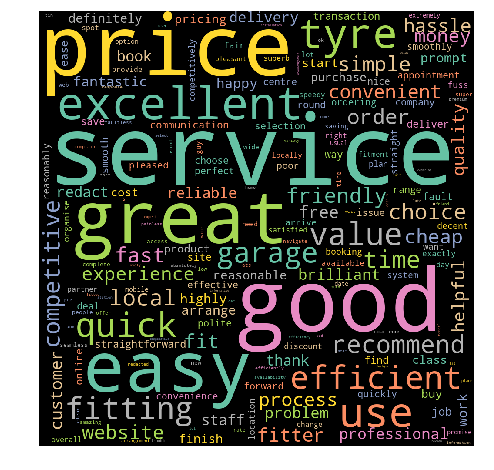

In [17]:
fig = plt.figure(figsize=(20,8))

text = ' '.join(f.loc[f['count']<=10,'document'].values)
wc = WordCloud(width=1000, 
                   height=1000, 
                   random_state=1, 
                   background_color='Black',
                   colormap='Set2',
                   collocations=False).generate(text)

plt.imshow(wc)
plt.axis("off");

### Observations
- most of the short reviews are good

In [18]:
df['char count'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Character Length Distribution')

### Observations
- Just like the average words, we can see the same distributions, most of the reviews are very short

In [19]:
df['avg word_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Average Word Length Distribution')

### Observation
- Most of the words fall in range of 3 to 10 in length, with 5 being the most common
- One of the reviews has an average word length of ~35

In [20]:
df['numeric_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review numeric count Distribution')

### Observations
- Most of the reviews dont have any numeric values
- There are some numeric values present, 12 being the highest number of numeric characters

In [21]:
df['upper_counts'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review number of upper case words Distribution')

### Observations
- Most of the review dont have any UPPER CASE characters
- Though we can see, that some of the reviews have high amount of UPPER CASE characters

## N-gram Visualization (1,2,3,4 grams)

In [22]:
def top_n_gram(corpus,r, n=None):
    vec = CountVectorizer(ngram_range=(r, r), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Unigrams

In [23]:
common_words = top_n_gram(df['document'], 1, 20)

tdf = pd.DataFrame(common_words, columns = ['document' , 'count'])
tdf.groupby('document').sum()['count'].sort_values(ascending=False).iplot(kind='bar', 
                                                                            yTitle='Count', 
                                                                            linecolor='black', 
                                                                            title='Top 20 unigrams');

### Bigrams

In [24]:
common_words = top_n_gram(df['document'], 2, 20)

tdf = pd.DataFrame(common_words, columns = ['document' , 'count'])
tdf.groupby('document').sum()['count'].sort_values(ascending=False).iplot(kind='bar', 
                                                                            yTitle='Count', 
                                                                            linecolor='black', 
                                                                            title='Top 20 bigrams');

### Tri grams

In [25]:
common_words = top_n_gram(df['document'], 3, 20)

tdf = pd.DataFrame(common_words, columns = ['document' , 'count'])
tdf.groupby('document').sum()['count'].sort_values(ascending=False).iplot(kind='bar', 
                                                                            yTitle='Count', 
                                                                            linecolor='black', 
                                                                            title='Top 20 trigrams');

### 4 grams

In [26]:
common_words = top_n_gram(df['document'], 4, 20)
    
tdf = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
tdf.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(kind='bar', 
                                                                            yTitle='Count', 
                                                                            linecolor='black', 
                                                                            title='Top 20 4-grams')

### Observations
- Most of the words revolve around 'service','great','easy' and 'tyres'

# Topic Assignment (Task 1)

### Motivation for the model
- Since we know the number of topics, we will be using Latent Dirichlet Allocation with number of topics at 12. 
- We will also not be needing to compare different models to get best number of topic
- We will use random_state, so that the results can be reproduced
- We will be fitting the model into the vectorized data, and transform it on the same
- After fitting the model, we will print the top 10 words of each topic
- We will be assigning the *provided topic*, based on the closest topic given by LDA, *manually*
- After getting the topics, we will be creating a new column and assign the topic

In [27]:
# Use LDA to look for 12 topics
n_topics = 12
model_lda = LatentDirichletAllocation(n_components=n_topics,random_state=0)
model_lda.fit(data_cv)

# Print the top 10 words per topic
n_words = 10
feature_names = cvectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model_lda.components_):
    top_n = [feature_names[i]
              for i in topic.argsort()
               [-n_words:]][::-1]
    
    top_features = ' '.join(top_n)
    
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}: {top_features}")
    print('\n\n\n')
    
topic_result = model_lda.transform(data_cv)
df['topic']  = topic_result.argmax(axis=1)

Topic 0: good price tyre use website good easy use website easy use website good tyre competitive price website good price good value tyre good price easy service reasonable price price easy book




Topic 1: price great service great price great excellent customer service excellent service good great price great service great value money good price great service good price excellent service good price service highly recommend




Topic 2: good value money way buy tyre website easy use good price service easy use website easy way buy definitely use recommend easy way buy tyre competitive price easy use website great




Topic 3: service great price great service great great service great price excellent service great tyre deliver time use web site easy use web easy use web site good tyre good easy use service




Topic 4: second time use good price easy service start finish time use redact second time use redact good quality tyre definitely use redact easy use great tyre local garage u

### Motivation for topic assignments
- After getting the top 10 words, we will also see the wordcloud of all the topics
- This will be done, to get a better idea of which topic given by the LDA suits best with the provided topic

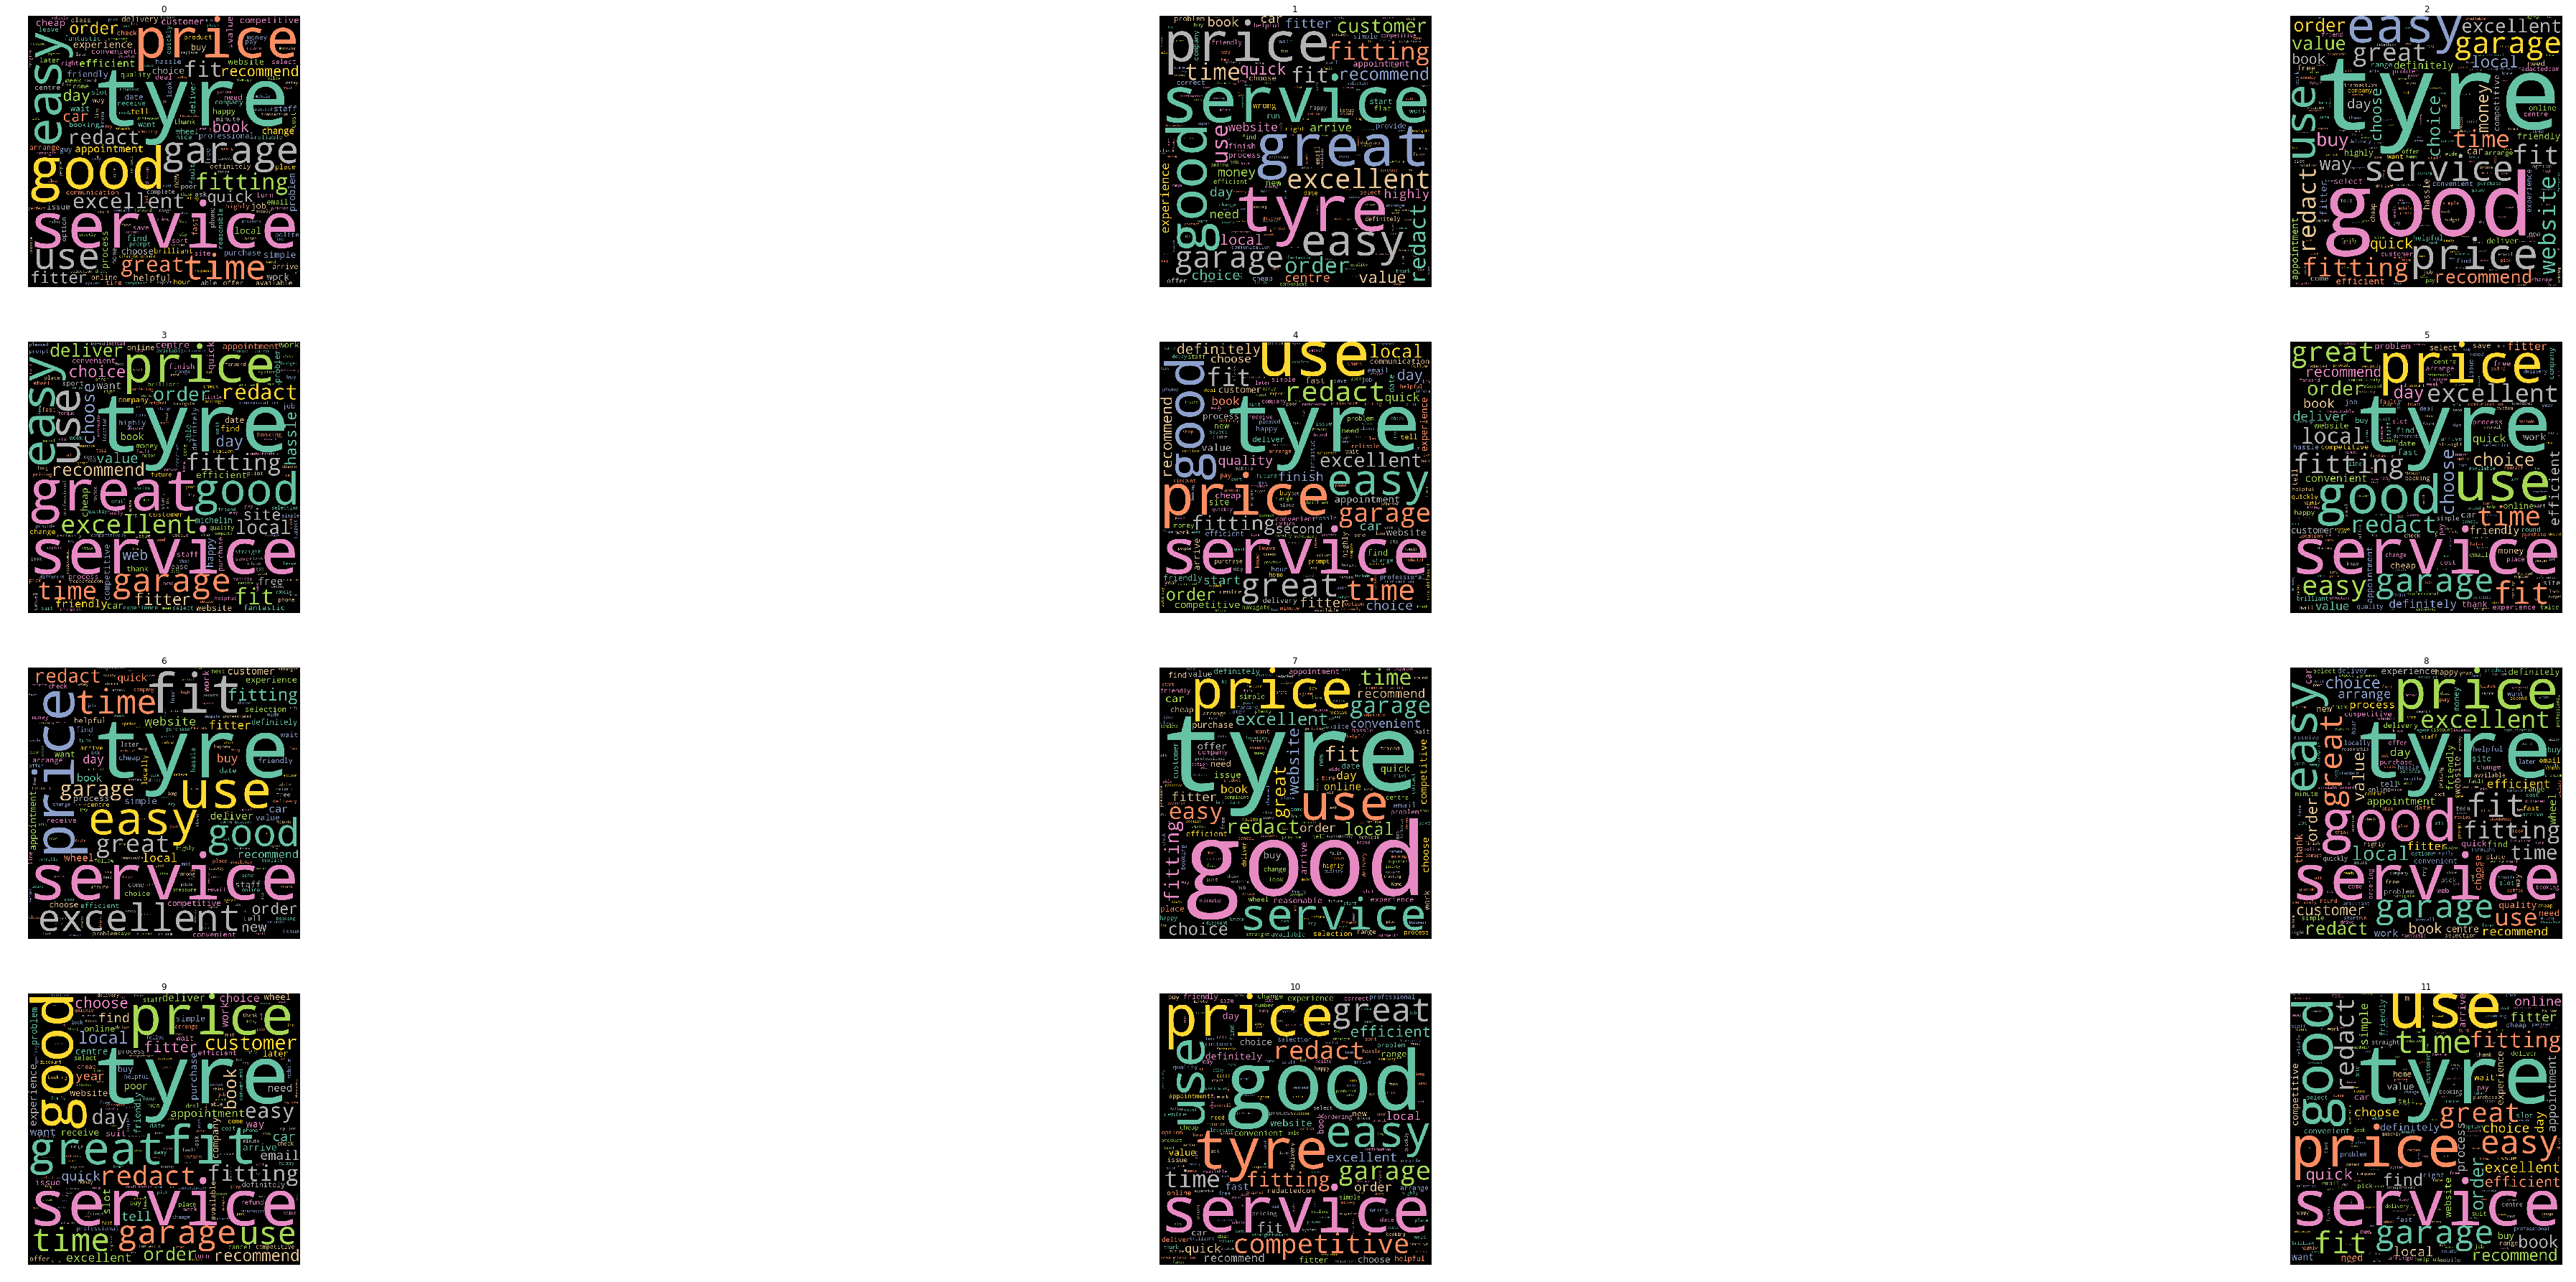

In [28]:
fig = plt.figure(figsize=(80,32))
for i in range(12):
    ax = fig.add_subplot(4,3,i+1)
    topic = i
    text = ' '.join(df.loc[df['topic']==i,'document'].values)
    wc = WordCloud(width=1000, 
                   height=1000, 
                   random_state=1, 
                   background_color='Black',
                   colormap='Set2',
                   collocations=False).generate(text)
    ax.imshow(wc)
    ax.set_title(topic)
    ax.axis("off");

Using a simple function we will apply the topics, and use .apply to map them

In [29]:
def assign_topic(x):
    if x==0:
        return "value for money"
    elif x==1:
        return "location"
    elif x==2:
        return "garage service"
    elif x==3:
        return "length of fitting"
    elif x==4:
        return "mobile fitter"
    elif x==5:
        return "tyre quality"
    elif x==6:
        return "delivery punctuality"
    elif x==7:
        return "booking confusion"
    elif x==8:
        return "ease of booking"
    elif x==9:
        return "wait time"
    elif x==10:
        return "change of date"
    elif x==11:
        return "discounts"
    
df['topic'] = df['topic'].apply(lambda x:assign_topic(x))

### Visualizing
Next we will see, which topics are distributed in which way, this is important because we will have to build a classifier based on this

In [30]:
df.groupby('topic').count()['document'].iplot(kind='bar', 
                                              yTitle='Count', 
                                              linecolor='black', 
                                              opacity=0.8,
                                              title='Bar chart of Topic Name',
                                              xTitle='Topic Name')

### Observation
- There is a serious data imbalance problem. 
- To tackle this, we will use some kind of sampling technique in the next segment

## Shortcomings of the model
- We had to assign the topics with the provided topics, manually, which can cause errors
- Could not check if the topics assigned is correct or not
- Only one topic is assigned, while ideally it should depend on what matches the best.
- In some documents, all the topics has same probability which will cause problems, as we are selecting only the max
- Some of words had no relation with the topic, such as *discount*, *change in date*

# Classifying (Task 2)

### Motivation for the model
- We store the original data into another dataset, and do encoding 
- The encoding is done for the naive bayes classifier to perform
- Pipeline from *imbalanced-learn* instead of sklearn, because the pipeline from sklearn does not support smote
- The model used is Multinomial naive bayes, as is masked by oneVsRest classifier to enable *multi label* classification
- To deal with the imbalanced class, oversampling is done
- The dataset is passed via tfidf vectorizer, as Naive Bayes needs vectorized data

In [31]:
#encoding
data=df[['document','topic']]
data = pd.get_dummies(data, columns=['topic'])

In [32]:
#splitting the data
train, test = train_test_split(data, random_state=42, test_size=0.33, shuffle=True)

X_train = train.document
X_test = test.document

#print the shape

print(X_train.shape)
print(X_test.shape)

(6787,)
(3344,)


In [33]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=STOP_WORDS)),
                ('smote', SMOTE(random_state=12)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

This is done for testing purposes

In [34]:
categories = ['topic_ease of booking', 
              'topic_value for money',
              'topic_garage service', 
              'topic_length of fitting', 
              'topic_mobile fitter', 
              'topic_tyre quality',
              'topic_delivery punctuality',
              'topic_booking confusion',
             'topic_location',
             'topic_wait time',
             'topic_change of date',
             'topic_discounts']

### Testing and Scoring
- We test the accuracy for each of the labels, since the data is imabalanced, it is important to see the accuracy of the model
- For testing, we run a loop through the categories and see if Category X in test matches correctly with original category

In [35]:
for category in categories:
    print('... Processing {}'.format(category))

    NB_pipeline.fit(X_train, train[category])

    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing topic_ease of booking


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



Test accuracy is 0.6728468899521531
... Processing topic_value for money
Test accuracy is 0.6495215311004785
... Processing topic_garage service
Test accuracy is 0.6857057416267942
... Processing topic_length of fitting
Test accuracy is 0.7200956937799043
... Processing topic_mobile fitter
Test accuracy is 0.6818181818181818
... Processing topic_tyre quality
Test accuracy is 0.6324760765550239
... Processing topic_delivery punctuality
Test accuracy is 0.6698564593301436
... Processing topic_booking confusion
Test accuracy is 0.6964712918660287
... Processing topic_location
Test accuracy is 0.6913875598086124
... Processing topic_wait time
Test accuracy is 0.7054425837320574
... Processing topic_change of date
Test accuracy is 0.6875
... Processing topic_discounts
Test accuracy is 0.6534090909090909


## Shortcomings of the model
- The model predicts only single label, this is because all the documents have single label, which should not be the case
- The accuracy is low $\approx 70\%$
- Better testing methods can also be used